In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from functions import *

In [2]:
result = pd.read_csv('../data/performances/topt_default_lr=0.0005.csv')

Text(0.5, 0.98, 'Topt_default')

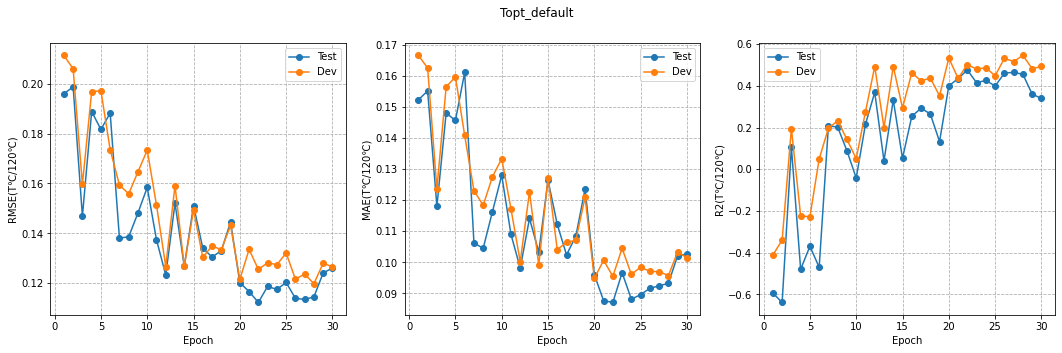

In [5]:
fig, axs = plt.subplots(1,3,figsize=(18,5))
axs[0].plot(result['Epoch'], result['rmse_test'], marker='o',label='Test')
axs[0].plot(result['Epoch'], result['rmse_dev'],marker='o', label='Dev')
axs[0].set_ylabel('RMSE(T\u2103/120\u2103)')
axs[1].plot(result['Epoch'], result['mae_test'], marker='o', label='Test')
axs[1].plot(result['Epoch'], result['mae_dev'], marker='o', label='Dev')
axs[1].set_ylabel('MAE(T\u2103/120\u2103)')
axs[2].plot(result['Epoch'], result['r2_test'], marker='o', label='Test')
axs[2].plot(result['Epoch'], result['r2_dev'], marker='o', label='Dev')
axs[2].set_ylabel('R2(T\u2103/120\u2103)')
for ax in axs:
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.grid(linestyle='--')
plt.suptitle('Topt_default')

# Hyperparam Opt Topt

In [3]:
param_dict = {}
for i in range(1,10):
    param_dict[i] = load_pickle('../data/hyparams/params_'+str(i)+'.pkl')
perform_dict = {} 
for i in range(1,10):
    filename = '../data/performances/topt_params_'+str(i)+'_lr=0.0005.csv'
    perform_dict[i] = pd.read_csv(filename)

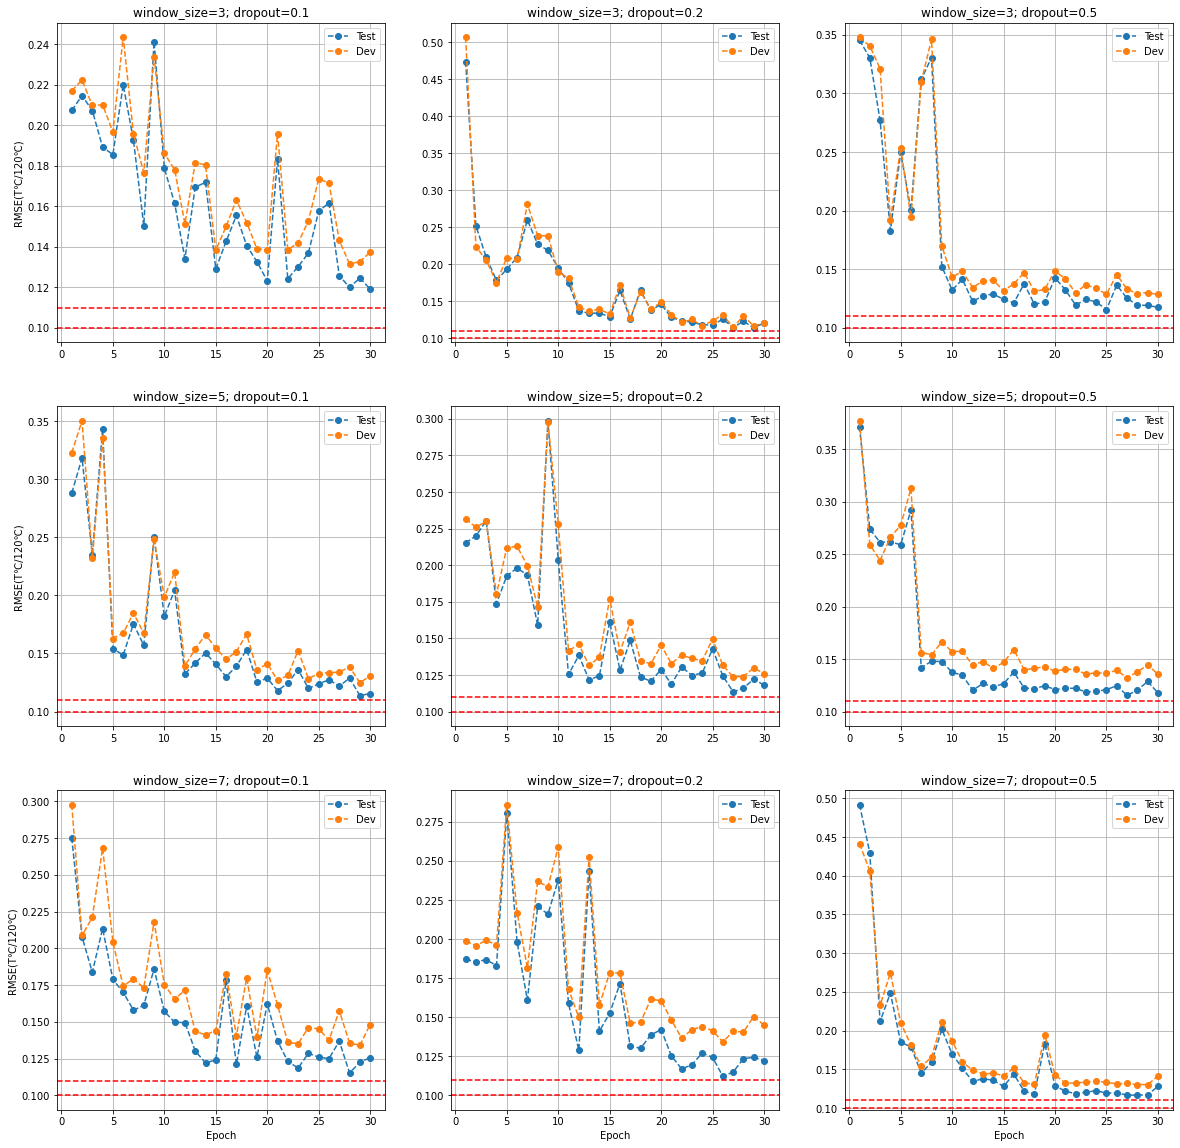

In [24]:
fig, axs = plt.subplots(3,3,figsize=(20,20))
for i in range(len(perform_dict.keys())):
    x,y = int(i/3), int(i%3)
    axs[x][y].plot( perform_dict[i+1]['Epoch'], perform_dict[i+1]['rmse_test'],'o--',label='Test' )
    axs[x][y].plot( perform_dict[i+1]['Epoch'], perform_dict[i+1]['rmse_dev'],'o--',label='Dev' )
    axs[x][y].legend()
    axs[x][y].grid()
    if y == 0:
        axs[x][y].set_ylabel('RMSE(T\u2103/120\u2103)')
    if x==2:
        axs[x][y].set_xlabel('Epoch')
    axs[x][y].set_title('window_size='+str(param_dict[i+1]['window'])+'; dropout='+str(param_dict[i+1]['dropout']))
    axs[x][y].axhline(y=0.1,color='r',ls='--')
    axs[x][y].axhline(y=0.11,color='r',ls='--')

In [3]:
# best_topt_param = { 'window':3,'dropout':0.2,'n_head':4,'n_RD':4 }
# dump_pickle( best_topt_param, '../data/hyparams/best_topt_param.pkl')

# Compare with Preoptem

In [11]:
ptem_out = pd.read_csv('../data/Test_preoptem/test_preoptem.fasta.pred',sep='\t')
topt_test = pd.read_csv('../data/Topt/test.csv')
ptem_pred = pd.DataFrame(zip(topt_test.uniprot_id, topt_test.topt,ptem_out.Predicted_optimal_temperature ),
                        columns=['ID','Exp','Pred'])

In [17]:
print( get_rmse( ptem_pred['Exp'], ptem_pred['Pred']) )
print( get_mae( ptem_pred['Exp'], ptem_pred['Pred']) )
print( get_r2( ptem_pred['Exp'], ptem_pred['Pred']) )

15.042145
11.232552
0.347743


# code test

In [8]:
import torch
import esm
import numpy as np
import pandas as pd
from functions import *
import timeit

In [6]:
train_data = pd.read_csv('../data/Topt/train_os.csv')
train_pack = [np.array(train_data.index), np.array(train_data.sequence), \
              np.array( rescale_targets(list(train_data['topt']), 120, 0)) ];

batch_data = [train_pack[di][10:14] for di in range(len(train_pack))]
ids, seqs, y = batch_data
input_data = [(ids[i], seqs[i]) for i in range(len(ids))]
device = torch.device('cpu')

In [9]:
esm2_model, alphabet = esm.pretrained.esm2_t33_650M_UR50D() # 33 layers
esm2_model = esm2_model.to(device)
esm2_batch_converter = alphabet.get_batch_converter()

start = timeit.default_timer()

batch_labels, batch_strs, batch_tokens = esm2_batch_converter(input_data)
batch_tokens = batch_tokens.to(device=device, non_blocking=True)
with torch.no_grad():
    emb = esm2_model(batch_tokens, repr_layers=[33], return_contacts=False)
emb = emb["representations"][33]
emb = emb.transpose(1,2) # (batch, features, seqlen)

stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  22.993406897061504


In [10]:
esm2_model, alphabet = esm.pretrained.esm2_t6_8M_UR50D() # 6 layers
esm2_model = esm2_model.to(device)
esm2_batch_converter = alphabet.get_batch_converter()

start = timeit.default_timer()

batch_labels, batch_strs, batch_tokens = esm2_batch_converter(input_data)
batch_tokens = batch_tokens.to(device=device, non_blocking=True)
with torch.no_grad():
    emb = esm2_model(batch_tokens, repr_layers=[6], return_contacts=False)
emb = emb["representations"][6]
emb = emb.transpose(1,2) # (batch, features, seqlen)

stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  0.5214503729948774
